In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import load_model
from os import listdir
from sklearn.utils import shuffle
from keras.preprocessing import image

In [2]:
LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 32

In [3]:
DIRECTORY = r"Face Mask Dataset/Train"
CATEGORIES = ["WithMask", "WithoutMask"]

In [4]:
print("[INFO] loading images...")

[INFO] loading images...


In [5]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [7]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [8]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [9]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
print("[INFO] compiling model...")
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


C:\Anaconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=EPOCHS)


[INFO] training head...
Epoch 1/20
250/250 [==============================] - 338s 1s/step - loss: 0.2351 - accuracy: 0.9146 - val_loss: 0.0633 - val_accuracy: 0.9830
Epoch 2/20
250/250 [==============================] - 291s 1s/step - loss: 0.0789 - accuracy: 0.9784
Epoch 3/20
250/250 [==============================] - 296s 1s/step - loss: 0.0656 - accuracy: 0.9806
Epoch 4/20
250/250 [==============================] - 290s 1s/step - loss: 0.0513 - accuracy: 0.9841
Epoch 5/20
250/250 [==============================] - 239s 954ms/step - loss: 0.0437 - accuracy: 0.9861
Epoch 6/20
250/250 [==============================] - 159s 633ms/step - loss: 0.0403 - accuracy: 0.9869
Epoch 7/20
250/250 [==============================] - 156s 623ms/step - loss: 0.0385 - accuracy: 0.9880
Epoch 8/20
250/250 [==============================] - 156s 622ms/step - loss: 0.0348 - accuracy: 0.9896
Epoch 9/20
250/250 [==============================] - 156s 622ms/step - loss: 0.0359 - accuracy: 0.9875
Epoch 10/2

In [14]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)


predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))


[INFO] evaluating network...
              precision    recall  f1-score   support

    WithMask       1.00      0.99      0.99      1000
 WithoutMask       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [15]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


[INFO] saving mask detector model...


C:\Anaconda\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Model Testing

In [14]:
model = load_model('mask_detector.model')

In [15]:
def predict_class(img_name, model):
    test_image = image.img_to_array(img_name)
    test_image = np.expand_dims(test_image, axis=0)
    test_image /= 255.
    prediction= np.argmax(model.predict(test_image), axis=-1)
    plt.figure(figsize=(3,3))
    plt.imshow(img_name)
    if prediction[0] ==1:
        print('With outMask')
    else:
        print('WithMask')
    return plt.show()

In [16]:
def loadImages(list_path):
    URL = "F:\Courses\AI\graduation Project\Face Mask Dataset/"
    loadedImages=[]
    for path in list_path:
        print("[INFO] loading "+path+" dataset . . . ")
        imagesList = listdir(URL+path)
        temp = []
        for image in imagesList:
            img = load_img(URL+path +"/"+ image, target_size=(224, 224))
            temp.append(img)
        loadedImages+=temp
    return loadedImages

In [17]:
df_test = loadImages(["Test/WithMask","Test/WithoutMask"])
df_test = shuffle(df_test, random_state=0)

[INFO] loading Test/WithMask dataset . . . 
[INFO] loading Test/WithoutMask dataset . . . 


With outMask


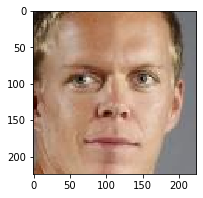

With outMask


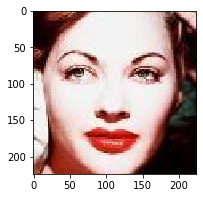

WithMask


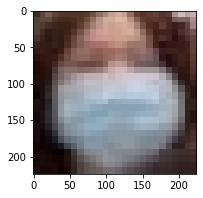

With outMask


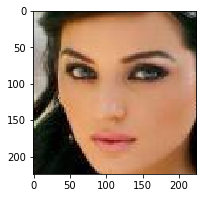

WithMask


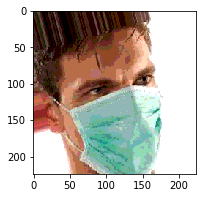

WithMask


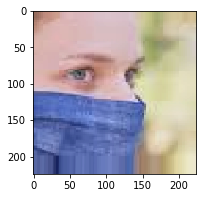

WithMask


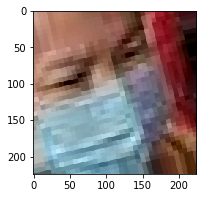

WithMask


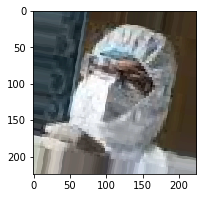

With outMask


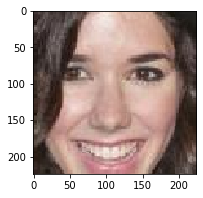

With outMask


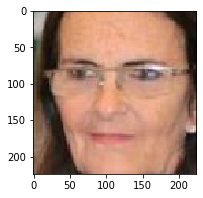

In [20]:
for i in range (10):
    predict_class(df_test[i], model)